#Лабораторная работа №5

#Введение

В данной лабораторной работе требуется:
1. Построить CNN для бинарной классификации изображений.
2. Загрузить датасет.
3. Выполнить аугментацию изображений
4. Обучить модель на обученном датасете.
5. Получить метрику ROC-AUC.
6. Добиться значения ROC_AUC>0.6

Дополнительное задание:
Сделать интерфейс, в который можно загружать изображения и получать инфрормацию о том, что человек находится на фото или лошадь

#Реализация

Импортируем библиотеки

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization

Распаковываем данные, если их еще нет

In [ ]:
zip_path = "/content/HoHD.zip"
extract_dir = "/content/horse_or_human"

if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)


base_dir = os.path.join(extract_dir, "horse-or-human")
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

Создание генераторов данных

In [ ]:
IMG_SIZE = 150
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


Модель CNN

Будем использовать метрику ROC-AUC, так как она показывает, насколько хорошо модель отличает один класс от другого, независимо от их количества.

In [ ]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


Обучение модели

In [ ]:
model.fit(
    train_generator,
    epochs=5,
    verbose=1
)

Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5610 - auc: 0.5730 - loss: 0.8246
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8587 - auc: 0.9394 - loss: 0.3859
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9334 - auc: 0.9831 - loss: 0.1709
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9450 - auc: 0.9917 - loss: 0.1220
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9515 - auc: 0.9941 - loss: 0.1204


Проверим модель

In [ ]:
test_loss, test_accuracy, test_auc = model.evaluate(test_generator, verbose=0)

print(f"\nРезультаты на тестовой выборке:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Результаты на тестовой выборке:
Test Loss: 1.7983
Test Accuracy: 0.8125
Test AUC: 0.8750


Видно, что ROC-AUC > 0.6

Дополнительное задание

Сделал минимальный интерфейс

Saving abca0ba143b5fc22fef1310696207132.jpg to abca0ba143b5fc22fef1310696207132 (10).jpg


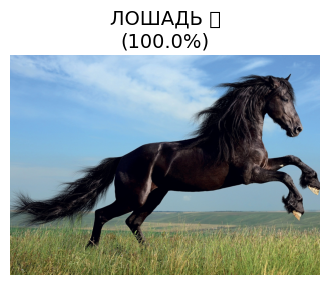

In [ ]:
from google.colab import files
from PIL import Image

def predict(image_path):

    # 1. Загружаем и обрабатываем изображение
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')

    img_resized = img.resize((IMG_SIZE, IMG_SIZE))

    # 2. Предсказание
    img_array = np.array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array, verbose=0)[0][0]

    # 3. Результат
    if prediction > 0.5:
        result = "ЧЕЛОВЕК 👤"
        confidence = prediction
    else:
        result = "ЛОШАДЬ 🐴"
        confidence = 1 - prediction

    # 4. Вывод изображения
    import matplotlib.pyplot as plt
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{result}\n({confidence:.1%})", fontsize=14)
    plt.show()

    return result, confidence

# Кнопка загрузки
uploaded = files.upload()

# Обработка
for filename in uploaded.keys():
    predict(filename)

#Заключение

Проделанная работа демонстрирует успешное построение свёрточной нейронной сети для бинарной классификации изображений "лошадь vs человек". Модель достигла точности 81.2% и ROC-AUC 0.875 на тестовой выборке, превысив порог в 0.6. Применение аугментации данных и Dropout слоя позволило снизить переобучение. Реализованный интерфейс позволяет загружать произвольные изображения и получать результат в реальном времени.